In [21]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import scipy
from scipy import io
import matplotlib.cm as cm
import random
from scipy.special import expit
from PIL import Image  # Add this import

In [22]:
datafile = 'data/ex3data1.mat'
mat = io.loadmat( datafile )
X, y = mat['X'], mat['y']
X = np.insert(X,0,1,axis=1)
print("'y' shape: %s. Unique elements in y: %s" % (y.shape, np.unique(y)))
print("'X' shape: %s. X[0] shape: %s" % (X.shape, X[0].shape))

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


In [23]:
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if indices_to_display is None or len(indices_to_display) == 0:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    # Convert to uint8 and create image
    img_array = (big_picture * 255).astype(np.uint8)
    img = Image.fromarray(img_array)
    plt.imshow(img, cmap=cm.Greys_r)

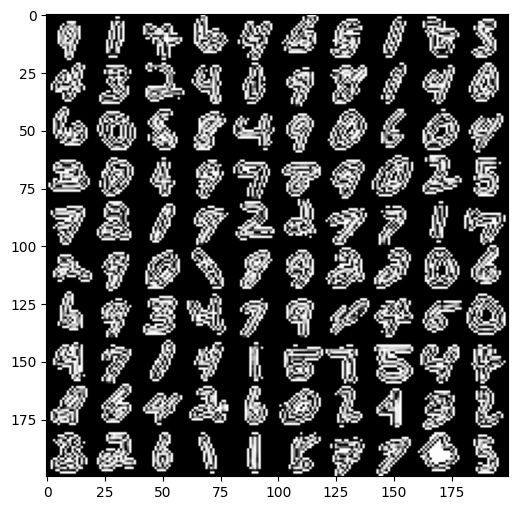

In [24]:
displayData()

In [25]:
def h(mytheta,myX):
    return expit(np.dot(myX,mytheta))

def computeCost(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0]
    myh = h(mytheta,myX)
    term1 = np.log( myh ).dot( -myy.T )
    term2 = np.log( 1.0 - myh ).dot( 1 - myy.T )
    left_hand = (term1 - term2) / m
    right_hand = mytheta.T.dot( mytheta ) * mylambda / (2*m)
    return left_hand + right_hand


In [26]:
def costGradient(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0]
    beta = h(mytheta,myX)-myy.T
    regterm = mytheta[1:]*(mylambda/m)
    grad = (1./m)*np.dot(myX.T,beta)
    grad[1:] = grad[1:] + regterm
    return grad


In [27]:
from scipy import optimize

def optimizeTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.fmin_cg(computeCost, fprime=costGradient, x0=mytheta, \
                              args=(myX, myy, mylambda), maxiter=50, disp=False,\
                              full_output=True)
    return result[0], result[1]

In [28]:
def buildTheta():
    """
    Function that determines an optimized theta for each class
    and returns a Theta matrix where each row corresponds
    to the learned logistic regression params for one class
    """
    mylambda = 0.
    initial_theta = np.zeros(X.shape[1])
    Theta = np.zeros((10,X.shape[1]))
    
    for i in range(10):
        # Correctly map digits: 1-9 use i, 0 maps to last row
        current_digit = i if i < 9 else 0
        iclass = i+1 if i < 9 else 10
        print("Optimizing for handwritten number %d..." % current_digit)
        
        # Create binary training set for current digit
        logic_Y = np.array([1 if x[0] == iclass else 0 for x in y])
        
        # Optimize parameters
        itheta, imincost = optimizeTheta(initial_theta, X, logic_Y, mylambda)
        
        # Store parameters in correct order (0-9)
        store_idx = i if i < 9 else 9
        Theta[store_idx,:] = itheta
        
    print("Done!")
    return Theta

In [29]:
Theta = buildTheta()

Optimizing for handwritten number 0...
Optimizing for handwritten number 1...
Optimizing for handwritten number 2...
Optimizing for handwritten number 3...
Optimizing for handwritten number 4...
Optimizing for handwritten number 5...
Optimizing for handwritten number 6...
Optimizing for handwritten number 7...
Optimizing for handwritten number 8...
Optimizing for handwritten number 0...
Done!


In [30]:

def predictOneVsAll(myTheta, myrow):
    """
    Function that computes hypothesis for each class and returns predicted digit
    """
    myrow = myrow.reshape(1, -1) if myrow.ndim == 1 else myrow
    
    hypotheses = expit(np.dot(myrow, myTheta.T))
    
    classes = list(range(1,10)) + [0]
    predicted_class = classes[np.argmax(hypotheses)]
    # Convert to match y format (where 10 represents 0)
    return 10 if predicted_class == 0 else predicted_class

predictions = np.array([predictOneVsAll(Theta, X[i]) for i in range(X.shape[0])])
predictions = predictions.reshape(-1, 1)

# Compare predictions with y
correct_predictions = (predictions == y)
accuracy = np.mean(correct_predictions) * 100

# Find indices where predictions were incorrect
incorrect_indices = np.where(~correct_predictions.flatten())[0]

print("Training set accuracy: %.1f%%" % accuracy)


Training set accuracy: 95.3%


In [31]:
n_correct, n_total = 0., 0.
incorrect_indices = []

predictions = np.array([predictOneVsAll(Theta, X[i]) for i in range(X.shape[0])])

correct_predictions = predictions.reshape(-1,1) == y
n_correct = np.sum(correct_predictions)
n_total = y.shape[0]

incorrect_indices = np.where(~correct_predictions.flatten())[0]

print("Training set accuracy: %.1f%%" % (100 * (n_correct/n_total)))

Training set accuracy: 95.3%


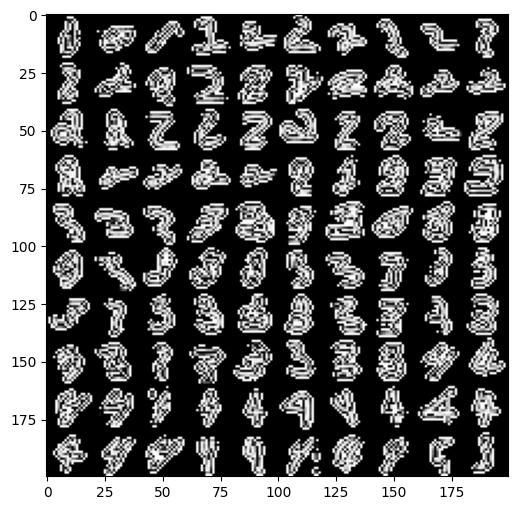

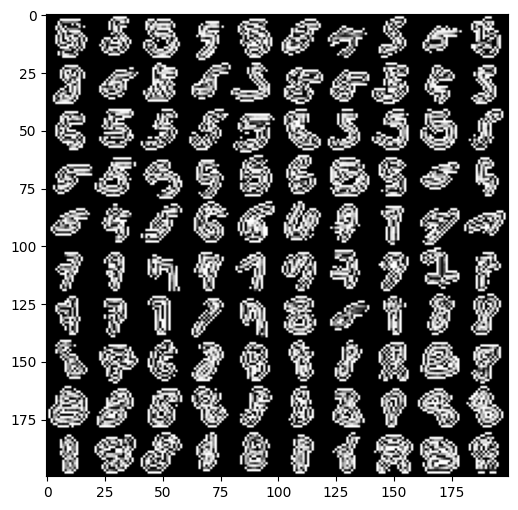

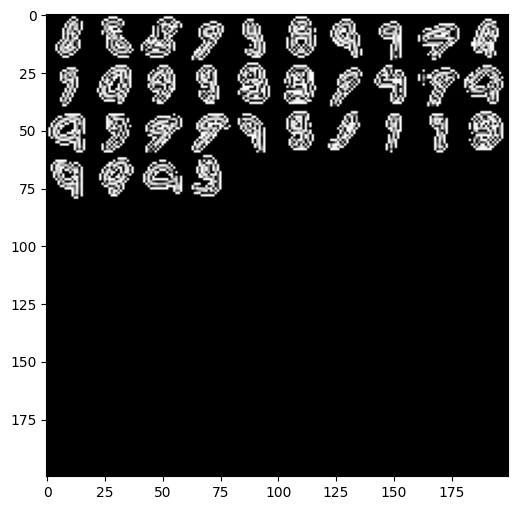

In [32]:
displayData(incorrect_indices[:100])
displayData(incorrect_indices[100:200])
displayData(incorrect_indices[200:300])

In [33]:
datafile = 'data/ex3weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
print("Theta1 has shape:",Theta1.shape)
print("Theta2 has shape:",Theta2.shape)

Theta1 has shape: (25, 401)
Theta2 has shape: (10, 26)


In [34]:
def propagateForward(row,Thetas):
    """
    Function that given a list of Thetas, propagates the
    Row of features forwards, assuming the features already
    include the bias unit in the input layer, and the 
    Thetas need the bias unit added to features between each layer
    """
    features = row
    for i in range(len(Thetas)):
        Theta = Thetas[i]
        z = Theta.dot(features)
        a = expit(z)
        if i == len(Thetas)-1:
            return a
        a = np.insert(a,0,1) 
        features = a

def predictNN(row,Thetas):
    """
    Function that takes a row of features, propagates them through the
    NN, and returns the predicted integer that was hand written
    """
    classes = list(range(1,10)) + [10]
    output = propagateForward(row,Thetas)
    return classes[np.argmax(np.array(output))]

In [35]:
myThetas = [ Theta1, Theta2 ]
n_correct, n_total = 0., 0.
incorrect_indices = []
for irow in range(X.shape[0]):
    n_total += 1
    if (predictNN(X[irow],myThetas) == int(y[irow])): 
        n_correct += 1
    else: incorrect_indices.append(irow)
print ("Training set accuracy: %0.1f%%"%(100*(n_correct/n_total)))

Training set accuracy: 97.5%


C:\Users\Sakshan Sharma\AppData\Local\Temp\ipykernel_16236\1467098929.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if (predictNN(X[irow],myThetas) == int(y[irow])):


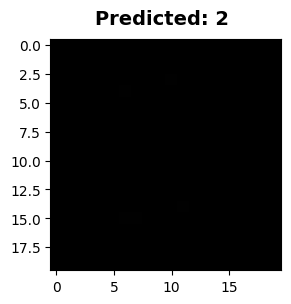

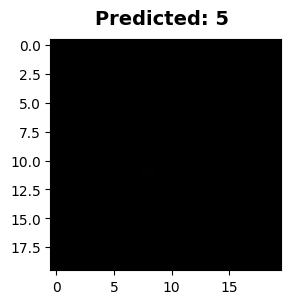

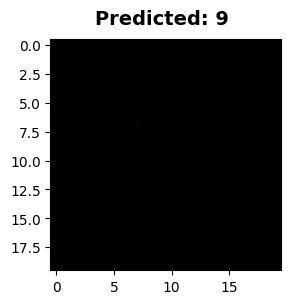

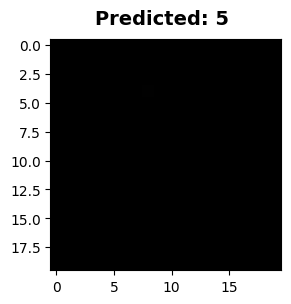

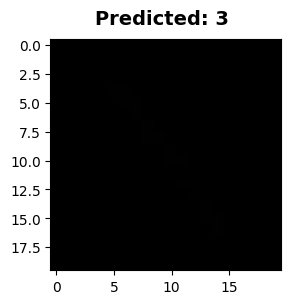

In [36]:
for x in range(5):
    i = random.choice(incorrect_indices)
    fig = plt.figure(figsize=(3,3))
    img = Image.fromarray( getDatumImg(X[i]) )
    plt.imshow(img,cmap = cm.Greys_r)
    predicted_val = predictNN(X[i],myThetas)
    predicted_val = 0 if predicted_val == 10 else predicted_val
    fig.suptitle('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')